# Modelling

## Now that we have an understanding of the variables that describe the problem, let's apply the necessary techniques for building the models.

# Installing the packages and downloading the necessary libraries

In [1]:
# !pip install imbalanced-learn

    100% |████████████████████████████████| 174kB 9.9MB/s eta 0:00:01
    100% |████████████████████████████████| 307kB 10.3MB/s ta 0:00:01
    100% |████████████████████████████████| 6.9MB 7.0MB/s eta 0:00:01    64% |████████████████████▊           | 4.4MB 30.3MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import os
import io
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE

## Importing processed data

In [2]:
columns_to_read = ['dia_semana', 'uf', 'causa_acidente', 'tipo_acidente', 'fase_dia',
                   'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 
                   'pessoas', 'veiculos', 'target', 'tipo_acidente_reduz', 'holiday', 'vacation',
                   'br_101', 'br_116', 'br_381', 'br_040', 'br_153', 'br_364', 'br_163', 'br_277', 
                   'br_376', 'br_262', 'urbano', 'ano']

In [3]:
data_dir = './dataframe'
df = pd.read_csv(os.path.join(data_dir, 'df_dtran_clean1.csv'), usecols=columns_to_read)
df.shape

(245486, 28)

In [4]:
df.head()

,dia_semana,uf,causa_acidente,tipo_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,...,br_116,br_381,br_040,br_153,br_364,br_163,br_277,br_376,br_262,urbano
0,quarta-feira,TO,Animais na Pista,Atropelamento de Animal,Plena Noite,Crescente,Nublado,Simples,Reta,Não,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,quarta-feira,RJ,Falta de Atenção do Pedestre,Atropelamento de Pedestre,Plena Noite,Decrescente,Céu Claro,Dupla,Reta,Sim,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,quarta-feira,SC,Ingestão de Álcool,Colisão lateral,Plena Noite,Crescente,Nublado,Simples,Reta,Sim,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,quarta-feira,RO,Velocidade Incompatível,Saída de leito carroçável,Plena Noite,Decrescente,Nublado,Simples,Reta,Sim,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,quarta-feira,PR,Ingestão de Álcool,Capotamento,Plena Noite,Crescente,Garoa/Chuvisco,Simples,Curva,Não,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_train = pd.get_dummies(df, drop_first=True)

In [6]:
df_holdout = df_train[df_train['ano'] == 2020]

df_train = df_train[df_train['ano'] != 2020]

df_holdout.shape, df_train.shape

((19537, 123), (225949, 123))

In [7]:
X = df_train.drop(['target', 'ano'], axis=1)
y = df_train['target']
X.shape, y.shape

((225949, 121), (225949,))

In [8]:
X_hold = df_holdout.drop(['target', 'ano'], axis=1)
y_hold = df_holdout['target']
X_hold.shape, y_hold.shape

((19537, 121), (19537,))

## Resampling

In [9]:
resampler = SMOTE(random_state=1)
X_res, y_res = resampler.fit_sample(X, y.values.ravel())
print(X_res.shape, y_res.shape)

(462675, 121) (462675,)


In [10]:
x_df = pd.DataFrame(X_res)
y_df = pd.DataFrame(y_res)

In [11]:
train_smote = pd.concat([x_df, y_df], axis=1)
train_smote.to_csv('dataframe/train_smote.csv')

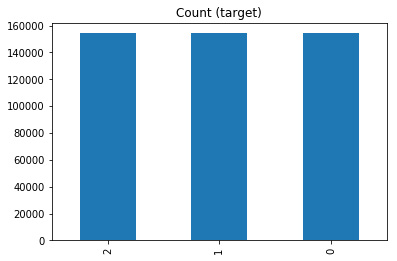

In [12]:
train_smote.iloc[:,-1].value_counts().plot(kind='bar', title='Count (target)');

# Baseline model: Linear Regression

In [13]:
# split into train/test
def train_test_split(transaction_df, train_frac= 0.7, seed=1):
    '''Shuffle the data and randomly split into train and test sets;
       separate the class labels (the column in transaction_df) from the features.
       :param df: Dataframe of all credit card transaction data
       :param train_frac: The decimal fraction of data that should be training data
       :param seed: Random seed for shuffling and reproducibility, default = 1
       :return: Two tuples (in order): (train_features, train_labels), (test_features, test_labels)
       '''
    
    # convert the df into a matrix for ease of splitting
    df_matrix = transaction_df.to_numpy()
    
    # shuffle the data
    np.random.seed(seed)
    np.random.shuffle(df_matrix)
    
    # split the data
    train_size = int(df_matrix.shape[0] * train_frac)
    # features are all but last column
    train_features  = df_matrix[:train_size, :-1]
    # class labels *are* last column
    train_labels = df_matrix[:train_size, -1]
    # test data
    test_features = df_matrix[train_size:, :-1]
    test_labels = df_matrix[train_size:, -1]
    
    return (train_features, train_labels), (test_features, test_labels)

In [14]:
# get train/test data
(train_features, train_labels), (test_features, test_labels) = train_test_split(train_smote, train_frac=0.7)

In [15]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [16]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'baseline'
output_path = 's3://{}/{}'.format(bucket, prefix)

# define the model instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=25,
                       num_classes=3,
                       predictor_type='multiclass_classifier',
                       balance_multiclass_weights='true',
                       early_stopping_patience=5,
                       loss='softmax_loss')

In [17]:
# convert features/labels to numpy
train_x_np = train_features.astype('float32')
train_y_np = train_labels.astype('float32')

# create RecordSet
formatted_train_data = linear.record_set(train_x_np, labels=train_y_np)

In [18]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

2020-06-27 18:51:50 Starting - Starting the training job...
2020-06-27 18:51:52 Starting - Launching requested ML instances......
2020-06-27 18:53:01 Starting - Preparing the instances for training.........
2020-06-27 18:54:30 Downloading - Downloading input data...
2020-06-27 18:55:11 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/27/2020 18:55:14 INFO 140184802273088] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'ini

[2020-06-27 18:55:30.677] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 3, "duration": 15315, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6835076792808509, "sum": 0.6835076792808509, "min": 0.6835076792808509}}, "EndTime": 1593284130.677617, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 0}, "StartTime": 1593284130.677493}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7407660201223273, "sum": 0.7407660201223273, "min": 0.7407660201223273}}, "EndTime": 1593284130.677738, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 0}, "StartTime": 1593284130.677717}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7127055350383369, "sum": 0.7127055350383369, "min": 0.71270553503

[2020-06-27 18:55:46.440] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 15746, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6688578052816008, "sum": 0.6688578052816008, "min": 0.6688578052816008}}, "EndTime": 1593284146.441116, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1593284146.441012}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7352871435773631, "sum": 0.7352871435773631, "min": 0.7352871435773631}}, "EndTime": 1593284146.441206, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1593284146.441192}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6759330361192072, "sum": 0.6759330361192072, "min": 0.67593303611

[2020-06-27 18:56:01.640] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 15187, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6658770251200296, "sum": 0.6658770251200296, "min": 0.6658770251200296}}, "EndTime": 1593284161.640973, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1593284161.640856}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7345006700639755, "sum": 0.7345006700639755, "min": 0.7345006700639755}}, "EndTime": 1593284161.641077, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1593284161.641058}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6601662257522253, "sum": 0.6601662257522253, "min": 0.66016622575

[2020-06-27 18:56:16.802] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 15145, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6642570056265722, "sum": 0.6642570056265722, "min": 0.6642570056265722}}, "EndTime": 1593284176.802592, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1593284176.802496}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7337030582959438, "sum": 0.7337030582959438, "min": 0.7337030582959438}}, "EndTime": 1593284176.802683, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1593284176.802668}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6493141587201287, "sum": 0.6493141587201287, "min": 0.64931415872

[2020-06-27 18:56:31.955] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 15139, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6634774132129209, "sum": 0.6634774132129209, "min": 0.6634774132129209}}, "EndTime": 1593284191.955489, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1593284191.955371}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7328647931456197, "sum": 0.7328647931456197, "min": 0.7328647931456197}}, "EndTime": 1593284191.955576, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1593284191.955562}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6418169279777598, "sum": 0.6418169279777598, "min": 0.6418169279

[2020-06-27 18:56:47.195] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 15227, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6630653431422939, "sum": 0.6630653431422939, "min": 0.6630653431422939}}, "EndTime": 1593284207.195778, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1593284207.195649}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7321202343447659, "sum": 0.7321202343447659, "min": 0.7321202343447659}}, "EndTime": 1593284207.195883, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1593284207.195863}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.636631930986056, "sum": 0.636631930986056, "min": 0.636631930986

[2020-06-27 18:57:02.408] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 15197, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.662770562422903, "sum": 0.662770562422903, "min": 0.662770562422903}}, "EndTime": 1593284222.409092, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1593284222.408981}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7314267574345733, "sum": 0.7314267574345733, "min": 0.7314267574345733}}, "EndTime": 1593284222.409191, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1593284222.409177}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6328723204999517, "sum": 0.6328723204999517, "min": 0.6328723204999

[2020-06-27 18:57:17.625] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 17, "duration": 15203, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6625563832569418, "sum": 0.6625563832569418, "min": 0.6625563832569418}}, "EndTime": 1593284237.625199, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1593284237.625103}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.730773049369316, "sum": 0.730773049369316, "min": 0.730773049369316}}, "EndTime": 1593284237.625282, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1593284237.625265}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6301282872061242, "sum": 0.6301282872061242, "min": 0.6301282872061

[2020-06-27 18:57:32.827] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 15189, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6624205700192289, "sum": 0.6624205700192289, "min": 0.6624205700192289}}, "EndTime": 1593284252.827507, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1593284252.827389}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7301293476683437, "sum": 0.7301293476683437, "min": 0.7301293476683437}}, "EndTime": 1593284252.827617, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1593284252.827598}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.62807080474948, "sum": 0.62807080474948, "min": 0.62807080474948

[2020-06-27 18:57:47.932] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 21, "duration": 15089, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.66234374036287, "sum": 0.66234374036287, "min": 0.66234374036287}}, "EndTime": 1593284267.932894, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1593284267.932766}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7295085301827351, "sum": 0.7295085301827351, "min": 0.7295085301827351}}, "EndTime": 1593284267.932999, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1593284267.932981}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6265194224071208, "sum": 0.6265194224071208, "min": 0.6265194224071208

[2020-06-27 18:58:03.239] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 23, "duration": 15294, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6623021599264706, "sum": 0.6623021599264706, "min": 0.6623021599264706}}, "EndTime": 1593284283.239792, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1593284283.239685}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7288463193344258, "sum": 0.7288463193344258, "min": 0.7288463193344258}}, "EndTime": 1593284283.239883, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1593284283.239869}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.625328960973781, "sum": 0.625328960973781, "min": 0.6253289609

[2020-06-27 18:58:18.621] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 25, "duration": 15369, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6622802600211034, "sum": 0.6622802600211034, "min": 0.6622802600211034}}, "EndTime": 1593284298.621844, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1593284298.621605}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7282345259817024, "sum": 0.7282345259817024, "min": 0.7282345259817024}}, "EndTime": 1593284298.621928, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1593284298.621915}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6244204991579794, "sum": 0.6244204991579794, "min": 0.62442049

[2020-06-27 18:58:33.544] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 27, "duration": 14910, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6622756047204552, "sum": 0.6622756047204552, "min": 0.6622756047204552}}, "EndTime": 1593284313.544352, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1593284313.544248}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7276593592026654, "sum": 0.7276593592026654, "min": 0.7276593592026654}}, "EndTime": 1593284313.544478, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1593284313.544455}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6237219062545352, "sum": 0.6237219062545352, "min": 0.62372190

[2020-06-27 18:58:48.820] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 29, "duration": 15263, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6622759701755394, "sum": 0.6622759701755394, "min": 0.6622759701755394}}, "EndTime": 1593284328.820538, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1593284328.820418}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7271031290060226, "sum": 0.7271031290060226, "min": 0.7271031290060226}}, "EndTime": 1593284328.820634, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1593284328.82062}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6231823573629185, "sum": 0.6231823573629185, "min": 0.623182357

[2020-06-27 18:59:04.111] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 31, "duration": 15278, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6622763178680703, "sum": 0.6622763178680703, "min": 0.6622763178680703}}, "EndTime": 1593284344.111388, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1593284344.111269}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7265598165317216, "sum": 0.7265598165317216, "min": 0.7265598165317216}}, "EndTime": 1593284344.1115, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1593284344.11148}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6227648009309089, "sum": 0.6227648009309089, "min": 0.62276480093

[2020-06-27 18:59:19.164] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 33, "duration": 15040, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6622766447746348, "sum": 0.6622766447746348, "min": 0.6622766447746348}}, "EndTime": 1593284359.164743, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1593284359.16445}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7260004839350933, "sum": 0.7260004839350933, "min": 0.7260004839350933}}, "EndTime": 1593284359.164829, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 15}, "StartTime": 1593284359.164814}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6224390179424463, "sum": 0.6224390179424463, "min": 0.622439017

[2020-06-27 18:59:34.291] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 35, "duration": 15112, "num_examples": 324, "num_bytes": 172299904}
#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6622769694136392, "sum": 0.6622769694136392, "min": 0.6622769694136392}}, "EndTime": 1593284374.291674, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 16}, "StartTime": 1593284374.291564}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.7254478531119993, "sum": 0.7254478531119993, "min": 0.7254478531119993}}, "EndTime": 1593284374.291776, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 16}, "StartTime": 1593284374.291757}

#metrics {"Metrics": {"train_weighted_softmax_loss_objective": {"count": 1, "max": 0.6221827460604925, "sum": 0.6221827460604925, "min": 0.62218274


2020-06-27 19:00:23 Uploading - Uploading generated training model
2020-06-27 19:00:23 Completed - Training job completed
Training seconds: 353
Billable seconds: 353
CPU times: user 1.46 s, sys: 97.2 ms, total: 1.56 s
Wall time: 8min 45s


In [19]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!CPU times: user 255 ms, sys: 25.5 ms, total: 280 ms
Wall time: 7min 32s


In [20]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """

    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

In [21]:
print('Metrics for simple, LinearLearner.\n')

# get metrics for linear predictor
metrics = evaluate(linear_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True)

Metrics for simple, LinearLearner.

prediction (col)    0.0    1.0    2.0
actual (row)                         
0.0               36093   3619   6474
1.0                2729  35263   8133
2.0                4969  11032  30491

Recall:     0.647
Precision:  0.622
Accuracy:   0.625



## Calculation of the confusion matrix

In [22]:
prediction_batches = [linear_predictor.predict(batch) for batch in np.array_split(test_features.astype('float32'), 100)]
test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                             for batch in prediction_batches])

In [23]:
import itertools
from sklearn import metrics

class_names = ['no victims', 'injured', 'dead victims']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [24]:
# Compute confusion matrix

cnf_matrix = metrics.confusion_matrix(test_labels, test_preds)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[36093  3619  6474]
 [ 2729 35263  8133]
 [ 4969 11032 30491]]


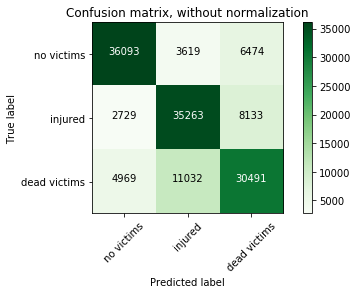

In [25]:
# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.78 0.08 0.14]
 [0.06 0.76 0.18]
 [0.11 0.24 0.66]]


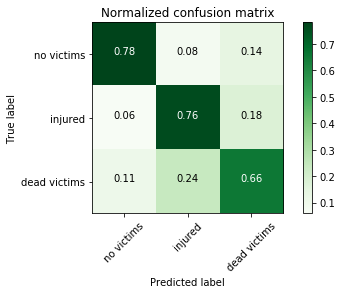

In [26]:
# Plot normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [27]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [28]:
# delete the predictor endpoint 
delete_endpoint(linear_predictor)

Deleted linear-learner-2020-06-27-18-51-50-374


# XGBoost

In [29]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import time
from time import gmtime, strftime

session = sagemaker.Session()

role = get_execution_role()

In [30]:
data_dir = './basic_xgboost'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [31]:
X = train_smote.iloc[:,:-1]
y = train_smote.iloc[:,-1]
X.shape, y.shape

((462675, 121), (462675,))

In [32]:
import sklearn

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

In [33]:
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)

pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [34]:
prefix = 'basic-xgboost-deploy'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)

train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [35]:
container = get_image_uri(session.boto_region_name, 'xgboost')


xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output, 
                                                                        # the model artifacts
                                    sagemaker_session=session) # The current SageMaker session

	get_image_uri(region, 'xgboost', '0.90-1').


In [36]:
xgb.set_hyperparameters(max_depth=6,
                        eta=0.4,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='multi:softmax', 
                        eval_metric= 'merror',
                        early_stopping_rounds=10,
                        num_class=3,
                        num_round=200,
                        seed=42)

In [37]:
%%time 
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')

s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-06-27 19:13:12 Starting - Starting the training job...
2020-06-27 19:13:14 Starting - Launching requested ML instances......
2020-06-27 19:14:23 Starting - Preparing the instances for training......
2020-06-27 19:15:18 Downloading - Downloading input data...
2020-06-27 19:16:10 Training - Training image download completed. Training in progress..Arguments: train
[2020-06-27:19:16:10:INFO] Running standalone xgboost training.
[2020-06-27:19:16:10:INFO] File size need to be processed in the node: 79.54mb. Available memory size in the node: 8488.2mb
[2020-06-27:19:16:10:INFO] Determined delimiter of CSV input is ','
[19:16:10] S3DistributionType set as FullyReplicated
[19:16:11] 207694x121 matrix with 25130974 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-06-27:19:16:11:INFO] Determined delimiter of CSV input is ','
[19:16:11] S3DistributionType set as FullyReplicated
[19:16:11] 102298x121 matrix with 12378058 entries loaded from /opt/ml/inpu

[19:16:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 38 pruned nodes, max_depth=6
[21]#011train-merror:0.279945#011validation-merror:0.288197
[19:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 50 pruned nodes, max_depth=6
[19:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 32 pruned nodes, max_depth=6
[19:16:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 36 pruned nodes, max_depth=6
[22]#011train-merror:0.277885#011validation-merror:0.286526
[19:16:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 40 pruned nodes, max_depth=6
[19:16:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 44 pruned nodes, max_depth=6
[19:16:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 62 pruned nodes, max_depth=6
[23]#011train-merror:0.276691#011validation-merror:0.28501
[19:16:52] src/tree/updater_pr

[19:17:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 36 pruned nodes, max_depth=6
[46]#011train-merror:0.251394#011validation-merror:0.261696
[19:17:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 36 pruned nodes, max_depth=6
[19:17:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 54 pruned nodes, max_depth=6
[19:17:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 38 pruned nodes, max_depth=6
[47]#011train-merror:0.250599#011validation-merror:0.260934
[19:17:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 32 pruned nodes, max_depth=6
[19:17:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 42 pruned nodes, max_depth=6
[19:17:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 28 pruned nodes, max_depth=6
[48]#011train-merror:0.249998#011validation-merror:0.260386
[19:17:32] src/tree/updater_p

[19:18:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 56 pruned nodes, max_depth=6
[71]#011train-merror:0.238914#011validation-merror:0.25021
[19:18:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 56 pruned nodes, max_depth=6
[19:18:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 32 pruned nodes, max_depth=6
[19:18:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 70 pruned nodes, max_depth=6
[72]#011train-merror:0.238562#011validation-merror:0.249888
[19:18:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 54 pruned nodes, max_depth=6
[19:18:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 44 pruned nodes, max_depth=6
[19:18:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 70 pruned nodes, max_depth=6
[73]#011train-merror:0.238317#011validation-merror:0.250269
[19:18:12] src/tree/updater_pr

[19:18:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 40 pruned nodes, max_depth=6
[19:18:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 40 pruned nodes, max_depth=6
[93]#011train-merror:0.232279#011validation-merror:0.243846
[19:18:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 42 pruned nodes, max_depth=6
[19:18:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 62 pruned nodes, max_depth=6
[19:18:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 70 pruned nodes, max_depth=6
[94]#011train-merror:0.232197#011validation-merror:0.24367
[19:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 50 pruned nodes, max_depth=6
[19:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 36 pruned nodes, max_depth=6
[19:18:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 52 pru

[19:19:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 54 pruned nodes, max_depth=6
[19:19:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 58 pruned nodes, max_depth=5
[115]#011train-merror:0.227758#011validation-merror:0.240024
[19:19:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 66 pruned nodes, max_depth=6
[19:19:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 70 pruned nodes, max_depth=6
[19:19:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 78 pruned nodes, max_depth=5
[116]#011train-merror:0.227359#011validation-merror:0.239858
[19:19:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 46 pruned nodes, max_depth=6
[19:19:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 58 pruned nodes, max_depth=6
[19:19:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 48 

[19:20:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 40 pruned nodes, max_depth=6
[19:20:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 72 pruned nodes, max_depth=0
[143]#011train-merror:0.222332#011validation-merror:0.235674
[19:20:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 58 pruned nodes, max_depth=6
[19:20:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 36 pruned nodes, max_depth=6
[19:20:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 90 pruned nodes, max_depth=4
[144]#011train-merror:0.222149#011validation-merror:0.235782
[19:20:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 38 pruned nodes, max_depth=6
[19:20:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 54 pruned nodes, max_depth=6
[19:20:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 78 p

[19:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 44 pruned nodes, max_depth=6
[19:20:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[162]#011train-merror:0.219279#011validation-merror:0.233211
[19:20:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 14 pruned nodes, max_depth=6
[19:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 70 pruned nodes, max_depth=6
[19:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 68 pruned nodes, max_depth=6
[163]#011train-merror:0.219236#011validation-merror:0.233152
[19:20:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 72 pruned nodes, max_depth=6
[19:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 60 pruned nodes, max_depth=6
[19:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 64 p

[19:21:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 38 pruned nodes, max_depth=6
[19:21:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 64 pruned nodes, max_depth=6
[181]#011train-merror:0.217748#011validation-merror:0.232204
[19:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 50 pruned nodes, max_depth=6
[19:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 72 pruned nodes, max_depth=6
[19:21:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 72 pruned nodes, max_depth=3
[182]#011train-merror:0.217517#011validation-merror:0.232155
[19:21:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 68 pruned nodes, max_depth=6
[19:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 50 pruned nodes, max_depth=6
[19:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 80 p

Training seconds: 383
Billable seconds: 383
CPU times: user 1.2 s, sys: 89.8 ms, total: 1.29 s
Wall time: 8min 45s


In [38]:
%%time 
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

CPU times: user 16.7 ms, sys: 7 µs, total: 16.7 ms
Wall time: 329 ms


In [39]:
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

In [40]:
%%time 
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

CPU times: user 16.7 ms, sys: 7 µs, total: 16.7 ms
Wall time: 351 ms


In [41]:
%%time 
xgb_transformer.wait()

.....................Arguments: serve
[2020-06-27 19:25:32 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-06-27 19:25:32 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-06-27 19:25:32 +0000] [1] [INFO] Using worker: gevent
[2020-06-27 19:25:32 +0000] [39] [INFO] Booting worker with pid: 39
[2020-06-27 19:25:32 +0000] [40] [INFO] Booting worker with pid: 40
[2020-06-27 19:25:32 +0000] [41] [INFO] Booting worker with pid: 41
[2020-06-27:19:25:32:INFO] Model loaded successfully for worker : 39
[2020-06-27 19:25:32 +0000] [42] [INFO] Booting worker with pid: 42
[2020-06-27:19:25:32:INFO] Model loaded successfully for worker : 40
[2020-06-27:19:25:32:INFO] Model loaded successfully for worker : 41
[2020-06-27:19:25:32:INFO] Model loaded successfully for worker : 42

[2020-06-27:19:26:04:INFO] Sniff delimiter as ','
[2020-06-27:19:26:04:INFO] Determined delimiter of CSV input is ','
[2020-06-27:19:26:04:INFO] Sniff delimiter as ','
[2020-06-27:19:26:04:INFO] Determined delimi

In [42]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-west-2-547991729607/xgboost-2020-06-27-19-22-14-588/test.csv.out to basic_xgboost/test.csv.out


In [43]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Test Evaluation: ")
print("\n{:<11} {:.3f}".format('Recall:', recall_score(Y_test, Y_pred, average='weighted')))
print("{:<11} {:.3f}".format('Precision:', precision_score(Y_test, Y_pred, average='weighted')))
print("{:<11} {:.3f}".format('Accuracy:', accuracy_score(Y_test, Y_pred)))
print()

Test Evaluation: 

Recall:     0.770
Precision:  0.770
Accuracy:   0.770



In [45]:
# Compute confusion matrix

cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[42506  3525  4757]
 [ 2885 39255  8861]
 [ 5216  9927 35751]]


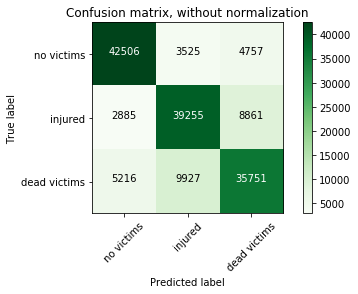

In [46]:
# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.84 0.07 0.09]
 [0.06 0.77 0.17]
 [0.1  0.2  0.7 ]]


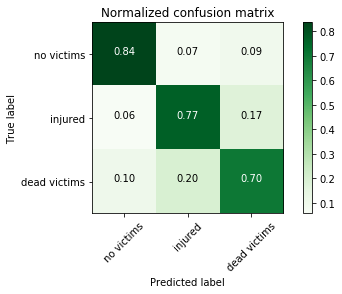

In [47]:
# Plot normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Tuning XGBoost Hyperparameters

In [48]:
data_dir = './tuned_xgboost'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [49]:
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)

pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [50]:
prefix = 'tuned-xgboost-deploy'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)

train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [51]:
container = get_image_uri(session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output,
                                                                        # the model artifacts
                                    sagemaker_session=session) # The current SageMaker session

	get_image_uri(region, 'xgboost', '0.90-1').


In [52]:
xgb.set_hyperparameters(max_depth=6,
                        eta=0.4,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='multi:softmax', 
                        early_stopping_rounds=10,
                        num_class=3,
                        num_round=200,
                        seed=42)

In [53]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:merror', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 10, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 15),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 12),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [54]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')

s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [55]:
%%time 
xgb_hyperparameter_tuner.wait()

..........................................................................................................................................................................................................................................................................................................................................................................................................................!
CPU times: user 2.23 s, sys: 88.4 ms, total: 2.32 s
Wall time: 34min 31s


In [56]:
%%time 
xgb_hyperparameter_tuner.best_training_job()

CPU times: user 4.63 ms, sys: 23 µs, total: 4.65 ms
Wall time: 41.6 ms


'xgboost-200627-1930-020-f19e771f'

In [57]:
%%time 
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2020-06-27 20:01:01 Starting - Preparing the instances for training
2020-06-27 20:01:01 Downloading - Downloading input data
2020-06-27 20:01:01 Training - Training image download completed. Training in progress.
2020-06-27 20:01:01 Uploading - Uploading generated training model
2020-06-27 20:01:01 Completed - Training job completedArguments: train
[2020-06-27:19:50:11:INFO] Running standalone xgboost training.
[2020-06-27:19:50:11:INFO] Setting up HPO optimized metric to be : merror
[2020-06-27:19:50:11:INFO] File size need to be processed in the node: 79.54mb. Available memory size in the node: 8476.65mb
[2020-06-27:19:50:11:INFO] Determined delimiter of CSV input is ','
[19:50:11] S3DistributionType set as FullyReplicated
[19:50:12] 207694x121 matrix with 25130974 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-06-27:19:50:12:INFO] Determined delimiter of CSV input is ','
[19:50:12] S3DistributionType set as FullyReplicated
[19:50:12] 102298x

In [58]:
%%time 
xgb_tuned = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

CPU times: user 30.2 ms, sys: 14.9 ms, total: 45.1 ms
Wall time: 581 ms


In [59]:
%%time 
xgb_tuned.transform(test_location, content_type='text/csv', split_type='Line')

CPU times: user 63.5 ms, sys: 4.91 ms, total: 68.5 ms
Wall time: 679 ms


In [60]:
%%time 
xgb_tuned.wait()

.........................Arguments: serve
[2020-06-27 20:08:38 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-06-27 20:08:38 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-06-27 20:08:38 +0000] [1] [INFO] Using worker: gevent
[2020-06-27 20:08:38 +0000] [38] [INFO] Booting worker with pid: 38
[2020-06-27 20:08:38 +0000] [39] [INFO] Booting worker with pid: 39
[2020-06-27 20:08:38 +0000] [40] [INFO] Booting worker with pid: 40
[2020-06-27 20:08:38 +0000] [41] [INFO] Booting worker with pid: 41
[2020-06-27:20:08:39:INFO] Model loaded successfully for worker : 38
[2020-06-27:20:08:39:INFO] Model loaded successfully for worker : 40
[2020-06-27:20:08:39:INFO] Model loaded successfully for worker : 39
[2020-06-27:20:08:39:INFO] Model loaded successfully for worker : 41
[2020-06-27:20:08:47:INFO] Sniff delimiter as ','
[2020-06-27:20:08:47:INFO] Determined delimiter of CSV input is ','
[2020-06-27:20:08:48:INFO] Sniff delimiter as ','
[2020-06-27:20:08:48:INFO] Determined del

In [61]:
!aws s3 cp --recursive $xgb_tuned.output_path $data_dir

download: s3://sagemaker-us-west-2-547991729607/xgboost-200627-1930-020-f19e771f-2020-06-27-20-04-41-971/test.csv.out to tuned_xgboost/test.csv.out


In [62]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [63]:
print("Test Evaluation: ")
print("\n{:<11} {:.3f}".format('Recall:', recall_score(Y_test, Y_pred, average='weighted')))
print("{:<11} {:.3f}".format('Precision:', precision_score(Y_test, Y_pred, average='weighted')))
print("{:<11} {:.3f}".format('Accuracy:', accuracy_score(Y_test, Y_pred)))
print()

Test Evaluation: 

Recall:     0.798
Precision:  0.797
Accuracy:   0.798



In [64]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[45084  3066  2638]
 [ 2496 39743  8762]
 [ 4008  9896 36990]]


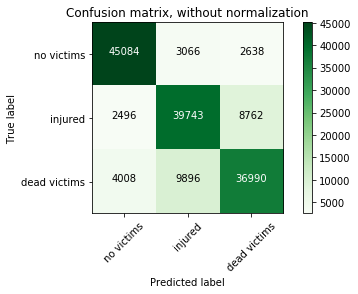

In [65]:
# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.89 0.06 0.05]
 [0.05 0.78 0.17]
 [0.08 0.19 0.73]]


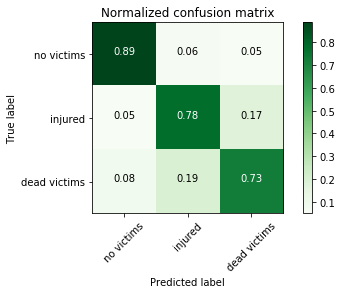

In [66]:
# Plot normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

## Deploy tuned model

In [67]:
xgb_predictor_tuned = xgb_hyperparameter_tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

2020-06-27 20:01:01 Starting - Preparing the instances for training
2020-06-27 20:01:01 Downloading - Downloading input data
2020-06-27 20:01:01 Training - Training image download completed. Training in progress.
2020-06-27 20:01:01 Uploading - Uploading generated training model
2020-06-27 20:01:01 Completed - Training job completedArguments: train
[2020-06-27:19:50:11:INFO] Running standalone xgboost training.
[2020-06-27:19:50:11:INFO] Setting up HPO optimized metric to be : merror
[2020-06-27:19:50:11:INFO] File size need to be processed in the node: 79.54mb. Available memory size in the node: 8476.65mb
[2020-06-27:19:50:11:INFO] Determined delimiter of CSV input is ','
[19:50:11] S3DistributionType set as FullyReplicated
[19:50:12] 207694x121 matrix with 25130974 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-06-27:19:50:12:INFO] Determined delimiter of CSV input is ','
[19:50:12] S3DistributionType set as FullyReplicated
[19:50:12] 102298x

-------------!

## Holdout validation

### The objective of this step is to evaluate the generalizability of the model using new data.

In [68]:
X_hold = df_holdout.drop(['target', 'ano'], axis=1)
y_hold = df_holdout['target']
X_hold.shape, y_hold.shape

((19537, 121), (19537,))

In [69]:
# This is our local data directory. We need to make sure that it exists.
data_dir = './holdout'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [70]:
X_hold.to_csv(os.path.join(data_dir, 'holdout.csv'), header=False, index=False)

In [71]:
holdout_location = session.upload_data(os.path.join(data_dir, 'holdout.csv'), key_prefix=prefix)

In [72]:
%%time 
xgb_tuned.transform(holdout_location, content_type='text/csv', split_type='Line')

CPU times: user 14.1 ms, sys: 0 ns, total: 14.1 ms
Wall time: 399 ms


In [73]:
%%time 
xgb_tuned.wait()

.....................Arguments: serve
[2020-06-27 20:26:37 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-06-27 20:26:37 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-06-27 20:26:37 +0000] [1] [INFO] Using worker: gevent
[2020-06-27 20:26:37 +0000] [38] [INFO] Booting worker with pid: 38
[2020-06-27 20:26:37 +0000] [39] [INFO] Booting worker with pid: 39
[2020-06-27 20:26:37 +0000] [40] [INFO] Booting worker with pid: 40
[2020-06-27 20:26:37 +0000] [41] [INFO] Booting worker with pid: 41
[2020-06-27:20:26:37:INFO] Model loaded successfully for worker : 39
[2020-06-27:20:26:37:INFO] Model loaded successfully for worker : 38
[2020-06-27:20:26:37:INFO] Model loaded successfully for worker : 40
[2020-06-27:20:26:37:INFO] Model loaded successfully for worker : 41

[2020-06-27:20:27:09:INFO] Sniff delimiter as ','
[2020-06-27:20:27:09:INFO] Determined delimiter of CSV input is ','
[2020-06-27:20:27:09:INFO] Sniff delimiter as ','
[2020-06-27:20:27:09:INFO] Determined delimi

In [74]:
!aws s3 cp --recursive $xgb_tuned.output_path $data_dir

download: s3://sagemaker-us-west-2-547991729607/xgboost-200627-1930-020-f19e771f-2020-06-27-20-23-17-849/holdout.csv.out to holdout/holdout.csv.out


In [75]:
Y_pred_h = pd.read_csv(os.path.join(data_dir, 'holdout.csv.out'), header=None)

In [76]:
preds_hold_xgb = Y_pred_h.to_numpy()
labels_hold_xgb = y_hold.to_numpy()

In [77]:
print("Test Evaluation: ")
print("\n{:<11} {:.3f}".format('Recall:', recall_score(labels_hold_xgb, preds_hold_xgb, average='weighted')))
print("{:<11} {:.3f}".format('Precision:', precision_score(labels_hold_xgb, preds_hold_xgb, average='weighted')))
print("{:<11} {:.3f}".format('Accuracy:', accuracy_score(labels_hold_xgb, preds_hold_xgb)))
print()

Test Evaluation: 

Recall:     0.691
Precision:  0.713
Accuracy:   0.691



In [78]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(labels_hold_xgb, preds_hold_xgb)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[  381   792   141]
 [  695 11455  2681]
 [   89  1637  1666]]


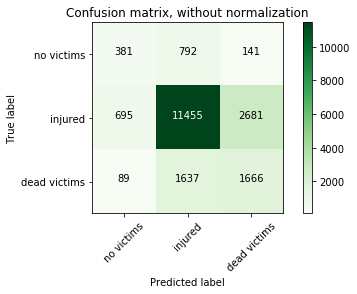

In [79]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.29 0.6  0.11]
 [0.05 0.77 0.18]
 [0.03 0.48 0.49]]


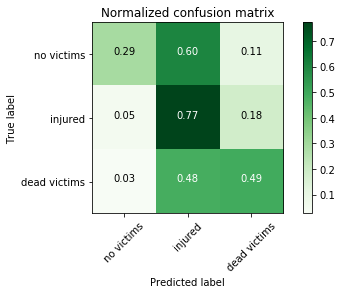

In [80]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

### Saves data for later analysis

In [81]:
data_dir = './dataframe'

df_aux = df[df['ano'] == 2020]

df_final_2020 = pd.concat([df_aux, Y_pred_h], axis=1)

df_final_2020.to_csv(os.path.join(data_dir, 'df_final_2020.csv'), index=False)